# Projeto PontUau pt.4 - Modelagem de Atraso de Voos e Criação do Modelo Preditivo

## Origem dos dados

Notebook anterior à esse: **LINK PARA A LOCALIZACAO DE TAL ARQUIVO NO REPOSITÓRIO DO GITHUB**

## Objetivo do Notebook

Preparar, numa modelagem preditiva final, os dados para possibilitar a criação do modelo preditivo

## Descrição do Notebook

Tendo em vista que a etapa anterior de Análise Exploratória de Dados (EDA) foi conduzida em Notebook separado - onde foram identificadas e validadas estatisticamente as variáveis mais relevantes para o problema -, neste Notebook, o foco está exclusivamente na preparação dos dados para modelagem, treinamento de modelos de classificação e avaliação de desempenho.

Portanto, o objetivo deste notebook é realizar a modelagem preditiva para estimar a probabilidade de atraso na partida de voos nacionais, utilizando informações disponíveis antes da realização do voo.

## Processo

### **Verificando versões dos pacotes**

In [ ]:
import sys
import numpy
import pandas
import sklearn
import xgboost
import scipy
import joblib
import matplotlib
import seaborn
import category_encoders

print("Python:", sys.version)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("scipy:", scipy.__version__)
print("xgboost:", xgboost.__version__)
print("category-encoders:", category_encoders.__version__)
print("joblib:", joblib.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
scipy: 1.16.3
xgboost: 3.1.2
category-encoders: 2.8.1
joblib: 1.5.3
matplotlib: 3.10.0
seaborn: 0.13.2


### Instalação e importação das bibliotecas

In [ ]:
# Instalação

!pip install category_encoders

In [ ]:
# Importação

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização (uso pontual)
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# métricas
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

#Salvar modelo
import joblib

# Configurações
pd.set_option("display.max_columns", None)
np.random.seed(42)

### Carregamento dos dados

O dataset utilizado neste notebook corresponde ao conjunto de voos nacionais previamente tratado na etapa de EDA.


In [ ]:
# Dataset base com features já validadas

vra_pre_ml = pd.read_parquet('/content/dataset_proprio.parquet')

In [ ]:
# Visualizando a estrutura dos dados

vra_pre_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199305 entries, 0 to 2199304
Data columns (total 42 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   icao_empresa_aerea       object        
 1   numero_voo               object        
 2   codigo_autorizacao_di    object        
 3   codigo_tipo_linha        object        
 4   icao_aerodromo_origem    object        
 5   icao_aerodromo_destino   object        
 6   partida_prevista         datetime64[ns]
 7   partida_real             datetime64[ns]
 8   chegada_prevista         datetime64[ns]
 9   chegada_real             datetime64[ns]
 10  situacao_voo             object        
 11  tempo_voo_estimado       float64       
 12  tempo_voo_real           float64       
 13  diferenca_previsao_real  float64       
 14  atraso_partida_min       float64       
 15  voo_com_atraso           int64         
 16  faixa_atraso_partida     object        
 17  hora_prevista            in

### Modelagem de Dados  
### Definição Final das Variáveis (Features) - Decisão Técnica

A seleção de features prioriza variáveis operacionais e contextuais, alinhadas com o objetivo de prever atrasos a partir de informações disponíveis antes da realização do voo.

Essa definição estabelece a base para o treinamento e avaliação dos modelos de classificação que serão apresentados nas próximas seções.

In [ ]:
colunas_ml = ['voo_com_atraso',
               'icao_empresa_aerea',
               'icao_aerodromo_origem',
               'icao_aerodromo_destino',
               'tempo_voo_estimado', # obtido por meio do cálculo (chegada_prevista - partida_prevista)
               'mes',
               'faixa_horaria',
               'distancia_km']

df = vra_pre_ml[colunas_ml]

df = df.rename(columns={'icao_empresa_aerea':'icao_empresa',
                        'tempo_voo_estimado':'tempo_voo_estimado_hr',
                        "faixa_horaria":"turno"
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199305 entries, 0 to 2199304
Data columns (total 8 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   voo_com_atraso          int64   
 1   icao_empresa            object  
 2   icao_aerodromo_origem   object  
 3   icao_aerodromo_destino  object  
 4   tempo_voo_estimado_hr   float64 
 5   mes                     int32   
 6   turno                   category
 7   distancia_km            float64 
dtypes: category(1), float64(2), int32(1), int64(1), object(3)
memory usage: 111.2+ MB


In [ ]:
# =====================================
# Definição das variáveis do modelo
# =====================================

# Variável alvo
target = "voo_com_atraso"

# Variáveis categóricas
features_categoricas = [
    "icao_empresa",
    "icao_aerodromo_origem",
    "icao_aerodromo_destino",
    "turno"
]

# Variáveis numéricas
features_numericas = [
    "tempo_voo_estimado_hr",
    "mes",
    "distancia_km"
]

# Lista final de features
features_modelo = features_categoricas + features_numericas


### Split temporal usando o dataset pré-ML

* **Observação:** Optou-se por não utilizar o split aleatório estratificado para que não houvesse o risco de vazamento temporal (data leakage), pois isso poderia causar uma avaliação não real.

In [ ]:
# Split temporal no dataset completo

treino = vra_pre_ml[vra_pre_ml["partida_prevista"] < "2025-01-01"]
teste = vra_pre_ml[vra_pre_ml["partida_prevista"] >= "2025-01-01"]

A separação entre os conjuntos de treino e teste foi realizada de forma temporal, utilizando o ano de realização do voo. O modelo será treinado com dados de 2023 e 2024 e, então, será avaliado com dados de 2025, de modo a simular um cenário real de previsão para evitar o vazamento de informação temporal.


### Criação do dataset de modelagem

Nesta etapa, é criado o dataset final para o modelo, contendo - somente - as variáveis selecionadas para o modelo de classificação, conforme definido na seção anterior.

Essa separação garante clareza, evita vazamento de informação e facilita a reprodutibilidade do pipeline de Machine Learning.


In [ ]:
# Criando a base para treinamento do modelo
treino = treino[colunas_ml].copy()
treino = treino.rename(columns={'icao_empresa_aerea':'icao_empresa',
                                'tempo_voo_estimado':'tempo_voo_estimado_hr',
                                "faixa_horaria":"turno"})

# Criando a base para teste do modelo
teste = teste[colunas_ml].copy()
teste = teste.rename(columns={'icao_empresa_aerea':'icao_empresa',
                              'tempo_voo_estimado':'tempo_voo_estimado_hr',
                              "faixa_horaria":"turno"})


# Separando cada parte
X_train = treino[features_modelo].copy()
y_train = treino[target].copy()

X_test = teste[features_modelo].copy()
y_test = teste[target].copy()

In [ ]:
# Validando

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(1498559, 7) (700746, 7)
0.16043412371484872 0.13674426967831427


Após o split temporal, observou-se uma proporção de voos com atraso de aproximadamente 16% no conjunto de treino e 13.7% no conjunto de teste.

Essa pequena variação reflete mudanças naturais ao longo do tempo e indica que a avaliação do modelo será realizada em um cenário realista.


### Pipeline + ColumnTransformer

Nesta etapa, é construído um pipeline de pré-processamento e modelagem utilizando `Pipeline` e `ColumnTransformer` do scikit-learn.  
Essa abordagem garante que todas as transformações aplicadas aos dados de treino sejam reproduzidas corretamente nos dados de teste e em produção, assim como na utilização da API, evitando inconsistências entre ambientes.


In [ ]:
# Pré-processamento com target Encoding
preprocessador_te = ColumnTransformer(
    transformers=[
        (
            "target_enc",
            TargetEncoder(
                smoothing=10,
                min_samples_leaf=50
            ),
            features_categoricas
        ),
        (
            "num",
            "passthrough",
            features_numericas
        )
    ]
)

In [ ]:
# Pré-processamento ONE HOT
preprocessador = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=True  # ← ESSENCIAL
            ),
            features_categoricas
        ),
        (
            "num",
            "passthrough",
            features_numericas
        )
    ]
)

### Modelagem Supervisionada

Aqui iremos testar 3 modelos:

1. **Logistic Regression**(Baseline)   

2. **Random Forest**(Ensemble Bagging)

3. **XGBoost**(Ensemble Boosting)

#### Logistic Regression — Baseline

**Tratamento da classe desbalanceada**

* class_weight="balanced"

In [ ]:
pipe_lr_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        ('imputer', SimpleImputer(strategy='mean')), # Added SimpleImputer
        (
            "model",
            LogisticRegression(
                max_iter=500,
                class_weight="balanced",
                solver="lbfgs",
                n_jobs=-1
            )
        )
    ]
)

#### Random Forest — Bagging

**Tratamento de desbalanceamento**

* class_weight="balanced"

In [ ]:
pipe_rf_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        ('imputer', SimpleImputer(strategy='mean')), # Added SimpleImputer
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=12,
                min_samples_leaf=100,
                class_weight="balanced",
                random_state=42,
                n_jobs=-1
            )
        )
    ]
)
print("pipe_rf_te updated with SimpleImputer.")

pipe_rf_te updated with SimpleImputer.


#### XGBoost — Boosting

**Tratamento de desbalanceamento**

* scale_pos_weight = negativos / positivos

In [ ]:
# Cálculo do peso da classe positiva
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [ ]:
pipe_xgb_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        ('imputer', SimpleImputer(strategy='mean')), # Added SimpleImputer
        (
            "model",
            XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="binary:logistic",
                scale_pos_weight=scale_pos_weight,
                eval_metric="logloss",   # usamos logloss aqui
                random_state=42,
                n_jobs=-1
            )
        )
    ]
)

**Justificativa de uso da métrica Log Loss:** No modelo XGBoost, a métrica Log Loss foi utilizada como função de otimização durante o treinamento, por ser adequada para classificação probabilística e dados desbalanceados. A avaliação do desempenho do modelo será realizada com métricas como ROC-AUC, Recall e Precision, alinhadas ao objetivo de identificar voos com maior risco de atraso.


### Métricas de Desempenho dos Modelos


As métricas que serão utilizadas:

* Accuracy -> será usada apenas para demonstrar que é uma métrica fraca nesse caso onde o foco é a classe desbalanceada

* ROC-AUC -> qualidade geral de separação

* Recall (classe atraso) -> o mais importante para o negócio

* Precision -> evita muitos falsos alarmes

* Log Loss -> qualidade das probabilidades

* Matriz de confusão -> interpretação visual dos erros

### Função utilitária de avaliação

In [ ]:
# Criando a função de avaliação dos modelos

def avaliar_modelo(pipe, X_train, y_train, X_test, y_test, nome_modelo):
    # Treino
    pipe.fit(X_train, y_train)

    # Probabilidades e previsões
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    ll = log_loss(y_test, y_proba)

    print(f"\n📌 Modelo: {nome_modelo}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"ROC-AUC   : {roc:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Log Loss  : {ll:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)

    plt.figure(figsize=(4,4))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusão – {nome_modelo}")
    plt.show()


### Treinando e avaliando os modelos

#### **Logistic Regression — Baseline**


📌 Modelo: Logistic Regression (Target Encoding)
Accuracy  : 0.5548
ROC-AUC   : 0.6033
Recall    : 0.5876
Precision : 0.1713
Log Loss  : 0.6695


<Figure size 400x400 with 0 Axes>

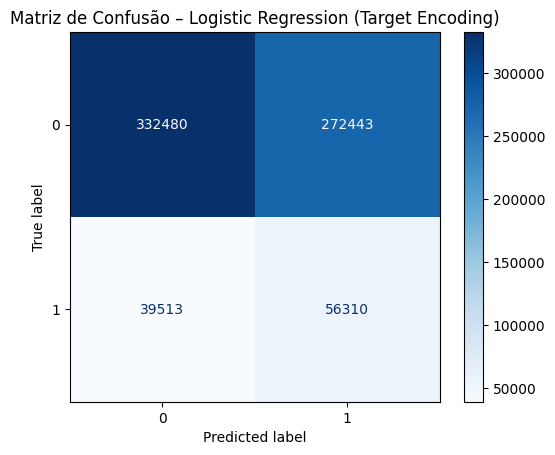

In [ ]:
avaliar_modelo(
    pipe_lr_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="Logistic Regression (Target Encoding)"
)

Metricas de Desempenho do modelo usando OHE apenas para comparação, visto que devido a alta cardinalidade do dataset que usamos para treinar, com OHE o treino foi extremamente custoso (demora de + de 15 minutos somente no modelo baseline).

---

 📌 Modelo: Logistic Regression (usando OHE)

Accuracy  : 0.5781

ROC-AUC   : 0.6106

Recall    : 0.5913

Precision : 0.2065

Log Loss  : 0.6694

<Figure size 400x400 with 0 Axes>


📌 Modelo: Logistic Regression (Target Encoding)
Accuracy  : 0.5548
ROC-AUC   : 0.6033
Recall    : 0.5876
Precision : 0.1713
Log Loss  : 0.6695


<Figure size 400x400 with 0 Axes>

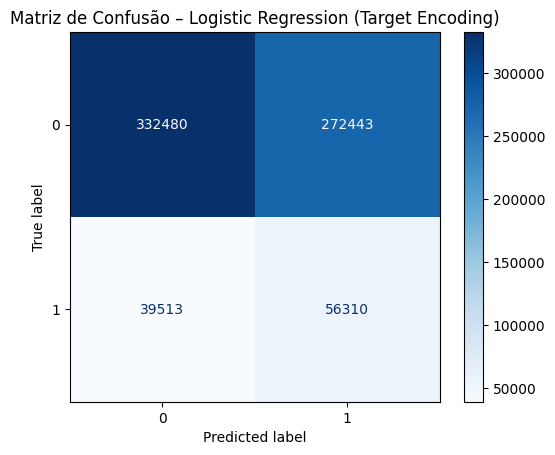

In [ ]:
# Usando target encoding
avaliar_modelo(
    pipe_lr_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="Logistic Regression (Target Encoding)"
)


A comparação entre One-Hot Encoding e Target Encoding no modelo baseline apresentou métricas praticamente idênticas.

Esse resultado indica que a mudança de codificação não afetou o poder preditivo do modelo linear, ao mesmo tempo em que reduziu significativamente o custo computacional.

Dessa forma, optou-se por Target Encoding como abordagem padrão para os modelos subsequentes.

#### **Random Forest — Bagging**


📌 Modelo: Random Forest (Target Encoding)
Accuracy  : 0.6367
ROC-AUC   : 0.6165
Recall    : 0.5046
Precision : 0.1892
Log Loss  : 0.6482


<Figure size 400x400 with 0 Axes>

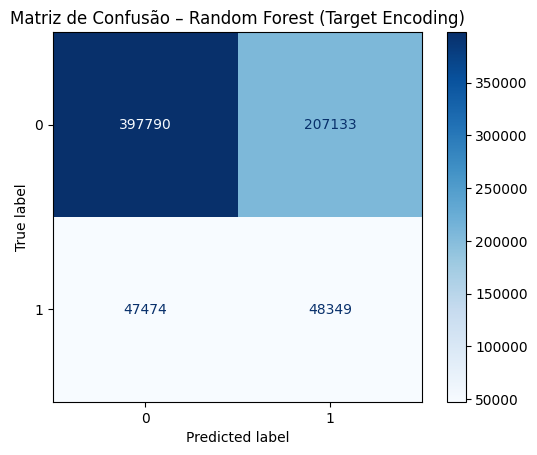

In [ ]:
avaliar_modelo(
    pipe_rf_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="Random Forest (Target Encoding)"
)

#### **XGBoost — Boosting**


📌 Modelo: XGBoost (Target Encoding)
Accuracy  : 0.6318
ROC-AUC   : 0.6185
Recall    : 0.5150
Precision : 0.1891
Log Loss  : 0.6473


<Figure size 400x400 with 0 Axes>

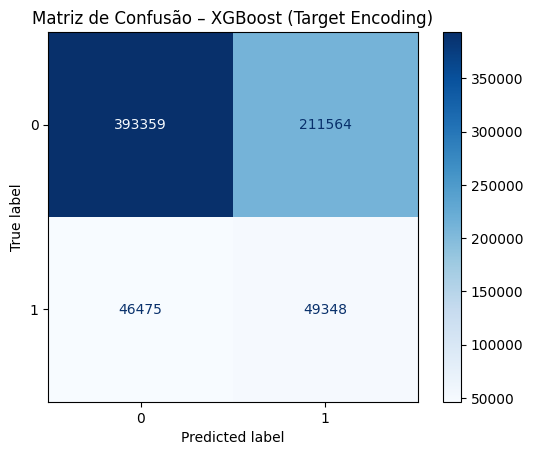

In [ ]:
avaliar_modelo(
    pipe_xgb_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="XGBoost (Target Encoding)"
)

### Curva ROC comparativa

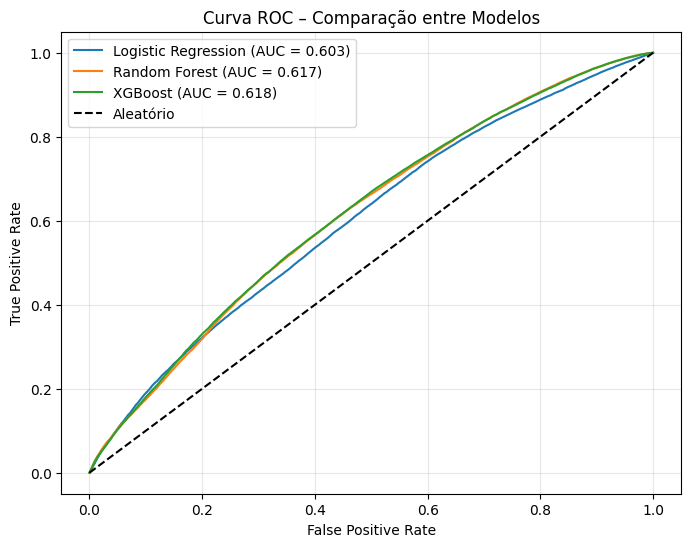

In [ ]:
plt.figure(figsize=(8, 6))

modelos = {
    "Logistic Regression": pipe_lr_te,
    "Random Forest": pipe_rf_te,
    "XGBoost": pipe_xgb_te,
}

for nome, modelo in modelos.items():
    # Probabilidade da classe positiva
    y_proba = modelo.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.3f})")

# Linha de referência (aleatório)
plt.plot([0, 1], [0, 1], "k--", label="Aleatório")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Comparação entre Modelos")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

* Mesmo sem dados externos, o modelo já consegue priorizar corretamente voos com maior risco de atraso mostrando que o modelo é melhor que aleatório.


A curva ROC evidencia uma melhora progressiva no poder discriminativo dos modelos, com o XGBoost apresentando a maior área sob a curva.

Apesar de os valores de ROC-AUC não serem elevados, o comportamento das curvas indica a presença de sinal real nos dados operacionais, ao mesmo tempo em que aponta limitações informacionais do dataset.

Esse resultado sugere que ganhos adicionais de performance estão mais associados à incorporação de dados externos do que à troca de algoritmos.

### Curva Recall × Threshold

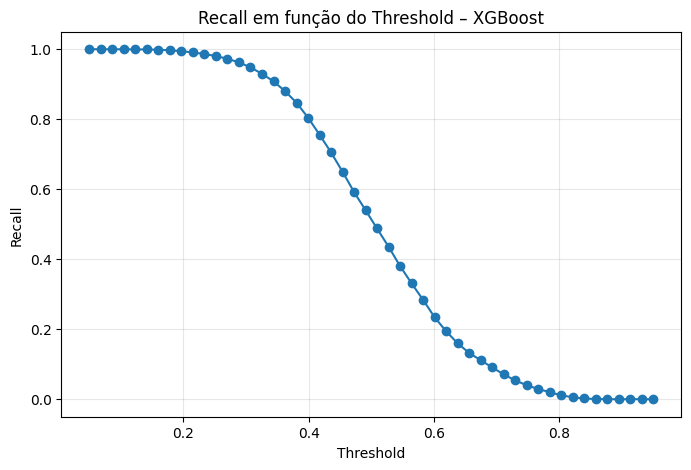

In [ ]:
thresholds = np.linspace(0.05, 0.95, 50)
recalls = []

y_proba_xgb = pipe_xgb_te.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall em função do Threshold – XGBoost")
plt.grid(alpha=0.3)
plt.show()


Através do gráfico é possível perceber que mantendo um Threshold médio(atual é 0.5), o modelo mantem um equilibrio entre os erros FN e FP muito embora o nosso objetivo seja detectar voos atrasados, o custo de o modelo avisar um atraso que não irá ocorrer também é alto por isso a melhor opção é manter um equilibrio podendo ajustar talvez o threshold para 0.4 ganhando mais de sensibilidade na detecção de atrasos.

---

## Resumo Comparativo dos Modelos Treinados

Foram avaliados três modelos de classificação: **Logistic Regression**, **Random Forest** e **XGBoost**, todos utilizando Target Encoding para variáveis categóricas de alta cardinalidade.

O modelo XGBoost apresentou o melhor equilíbrio entre poder discriminativo (ROC-AUC), capacidade de detecção de atrasos (Recall) e confiabilidade das previsões (Precision), sendo escolhido como modelo final para o problema proposto.


---

## Conclusões

Foram avaliados diferentes modelos de classificação para previsão de atraso de voos, incluindo Logistic Regression, Random Forest e XGBoost, utilizando apenas variáveis operacionais disponíveis antes da decolagem. Entre os modelos testados, o XGBoost com Target Encoding apresentou o melhor equilíbrio entre poder discriminativo (ROC-AUC), capacidade de detecção de atrasos (Recall) e confiabilidade das previsões (Precision), sendo escolhido como modelo final.

A análise da curva ROC confirmou a superioridade do modelo em relação aos demais, enquanto a curva Recall × Threshold evidenciou que o comportamento do modelo pode ser ajustado conforme a estratégia operacional adotada, sem necessidade de retreinamento.

## Limitações

Os resultados obtidos refletem limitações inerentes ao conjunto de dados utilizado, que contém majoritariamente informações operacionais. Fatores externos relevantes para o atraso de voos, como condições meteorológicas, restrições de tráfego aéreo e eventos operacionais extraordinários, não estão presentes na base atual, limitando o poder preditivo máximo dos modelos.


## Criando o Banco de Dados em .sql como requisitado pelo Back-End


In [ ]:
df_final = X_test.copy()
df_final["previsao_atraso"] = pipe_xgb_te.predict(X_test)
df_final["probabilidade_atraso"] = pipe_xgb_te.predict_proba(X_test)[:, 1]

cols_export = [
    "icao_empresa",
    "icao_aerodromo_origem",
    "icao_aerodromo_destino",
    "turno",
    "tempo_voo_estimado_hr",
    "mes",
    "distancia_km",
    "previsao_atraso",
    "probabilidade_atraso"
]

df_export = df_final[cols_export]

In [ ]:
import numpy as np

def export_to_mysql_sql(df, table_name, file_name):
    with open(file_name, "w") as f:
        # DROP TABLE statement for easy recreation
        f.write(f"DROP TABLE IF EXISTS `{table_name}`;\n")

        # CREATE TABLE
        f.write(f"CREATE TABLE `{table_name}` (\n")
        column_definitions = []
        for col_name, dtype in df.dtypes.items():
            sql_type = ""
            if pd.api.types.is_numeric_dtype(dtype):
                if pd.api.types.is_integer_dtype(dtype):
                    sql_type = "INT"
                else:
                    sql_type = "FLOAT"
            elif pd.api.types.is_string_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype):
                sql_type = "VARCHAR(255)" # Adjust size as needed
            else:
                sql_type = "TEXT"
            column_definitions.append(f"  `{col_name}` {sql_type}")
        f.write(",\n".join(column_definitions))
        f.write("\n);\n\n")

        # INSERTS
        for _, row in df.iterrows():
            values = []
            for v in row.values:
                if pd.isna(v):
                    values.append("NULL")
                elif isinstance(v, str):
                    values.append(f"'{v}'")
                elif isinstance(v, (int, float, np.integer, np.floating)):
                    values.append(str(v))
                else:
                    # Fallback for other types, treat as string
                    values.append(f"'{str(v)}'")
            f.write(f"INSERT INTO `{table_name}` VALUES ({', '.join(values)});\n")

In [ ]:
export_to_mysql_sql(
    df_export,
    table_name="previsoes_voos",
    file_name="previsoes_voos.sql"
)

/tmp/ipython-input-1004043535.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_string_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype):


---

## Salvando o modelo com joblib - XGboost

In [ ]:
artifact = {
    "model": pipe_xgb_te,  # Saving the entire pipeline
    "threshold_recomendado": 0.45,
    "feature_order": features_modelo # List of features the pipeline expects
}

joblib.dump(artifact, "modelo_previsao_atraso_voos.pkl")

['modelo_previsao_atraso_voos.pkl']

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700746 entries, 1498559 to 2199304
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   icao_empresa            700746 non-null  object  
 1   icao_aerodromo_origem   700746 non-null  object  
 2   icao_aerodromo_destino  700746 non-null  object  
 3   turno                   700746 non-null  category
 4   tempo_voo_estimado_hr   700746 non-null  float64 
 5   mes                     700746 non-null  int32   
 6   distancia_km            680589 non-null  float64 
 7   previsao_atraso         700746 non-null  int64   
 8   probabilidade_atraso    700746 non-null  float32 
dtypes: category(1), float32(1), float64(2), int32(1), int64(1), object(3)
memory usage: 43.4+ MB
